In [11]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [12]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [13]:
import math
from PIL import Image
from keras import backend as K
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

<h3>Load dataset and split</h3>

In [14]:
normalized_volumes = np.load("/kaggle/input/biocv-dataset-true/normalized_dataset.npy")
X = [np.expand_dims(image,axis=-1) for volume in normalized_volumes for image in volume]
X = np.array(X)

In [15]:
vols_labels = np.load("/kaggle/input/biocv-dataset-true/labels.npy")
y = [np.expand_dims(image,axis=-1) for volume in vols_labels for image in volume]
y = np.array(y)

X = X.astype(np.float32)
print(len(np.unique(y)))

5


In [16]:
from sklearn.utils import shuffle
X,y = shuffle(X,y, random_state = seed)

In [17]:
#Map original segmentation mask values to categorical encoding
segmentation_values_list = [0]+list(range(55,70)) +\
                            list(range(110, 135)) +\
                            list(range(175, 200)) +\
                            list(range(240, 255)) 
value_ranges = {
    (0,5) : 0,  #unlabelled
    (55, 70): 1, #Liver
    (110, 135): 2, #Right Kidney
    (175, 200): 3, #Left Kidney
    (240, 255): 4, #Spleen
}
def map_value_to_range(value, range_mapping):
    for value_range, label in range_mapping.items():
        if value_range[0] <= value <= value_range[1]:
            return label
    return -1
category_map = {value : map_value_to_range(value, value_ranges) for value in segmentation_values_list }
y = np.vectorize(category_map.get)(y)

num_classes = len(np.unique(y))
print('Number of classes',num_classes)

Number of classes 5


In [18]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=80, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=80, random_state=seed)

### Build ensemble

In [19]:
# Define a custom metric class for mean intersection over union (IoU)
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name="mean_iou", dtype=None, **kwargs):
        super(UpdatedMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype,**kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Define a callback class for visualization during training
class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label

    def on_epoch_end(self, epoch, logs=None):
        # Predict using the model and visualize ground truth vs predicted mask
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (256, 256, 1))
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].imshow(self.image[0], cmap='gray')
        axes[0].imshow(np.squeeze(self.label),alpha=0.5)
        axes[0].set_title("Ground Truth Mask")
        #colored_image = display_color_mapped_image_continuous(y_pred)
        axes[1].imshow(self.image[0], cmap='gray')
        axes[1].imshow(np.squeeze(y_pred),alpha=0.5)
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [20]:
#Load models for the ensemble
unet_augmented = tfk.models.load_model("/kaggle/input/unet-augmented/UNet_augmented.h5",custom_objects={"UpdatedMeanIoU":UpdatedMeanIoU})
multiresunet_augmented = tfk.models.load_model("/kaggle/input/multiresunet-augmented/MultiResUnet_augmented.h5",custom_objects={"UpdatedMeanIoU":UpdatedMeanIoU})

In [38]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = unet_augmented.evaluate(X_test, y_test, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.989
Test Mean Intersection over Union: 0.776


In [27]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = multiresunet_augmented.evaluate(X_test, y_test, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.9886
Test Mean Intersection over Union: 0.7703


In [25]:
#Change layers names for conflict problem in the ensemble
for layer in multiresunet_augmented.layers:
    layer._name = layer.name + str("_2")
multiresunet_augmented._name = "model_2"

In [35]:
#Define a function that returns the model ensemble
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Add

def weighted_sum_model(model1, model2, weight1, weight2):
    # Ensure that the output shapes of the two models match
    assert model1.output_shape == model2.output_shape, "Output shapes of the models must match"

    # Create input layer
    input_layer = tfkl.Input(shape=model1.input_shape[1:])

    # Get predictions from each model
    pred1 = model1(input_layer)
    pred2 = model2(input_layer)

    # Weighted sum
    weighted_sum = tfkl.Add()([tfkl.Lambda(lambda x: x * weight1)(pred1), tfkl.Lambda(lambda x: x * weight2)(pred2)])

    # Define the custom model
    custom_model = tfk.models.Model(inputs=input_layer, outputs=weighted_sum, name='weighted_sum_model')

    return custom_model

weight1 = 0.4
weight2 = 0.6

ensemble_model = weighted_sum_model(unet_augmented, multiresunet_augmented, weight1, weight2)


In [36]:

ensemble_model.compile(
    metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes)]
    )
ensemble_model.summary()


Model: "weighted_sum_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 256, 256, 5)          1181978   ['input_4[0][0]']             
                                                          1                                       
                                                                                                  
 model_2 (Functional)        (None, 256, 256, 5)          7262720   ['input_4[0][0]']             
                                                                                                  
 lambda_6 (Lambda)           (None, 256, 256, 5)          0         ['model[3][0]

In [37]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = custom_model.evaluate(X_test, y_test, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.9891
Test Mean Intersection over Union: 0.777


## Plot confusion matrix

In [ ]:
# Get model predictions on the test set
y_pred = custom_model.predict(X_test)

y_pred = np.array(tf.math.argmax(y_pred, axis=-1))
y_pred = np.reshape(y_pred, (80,256, 256, 1))

# Reshape to 1D arrays
y_pred_flat = y_pred.flatten()
y_test_flat = y_test.flatten()


# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)


3/3 [==============================] - 1s 367ms/step


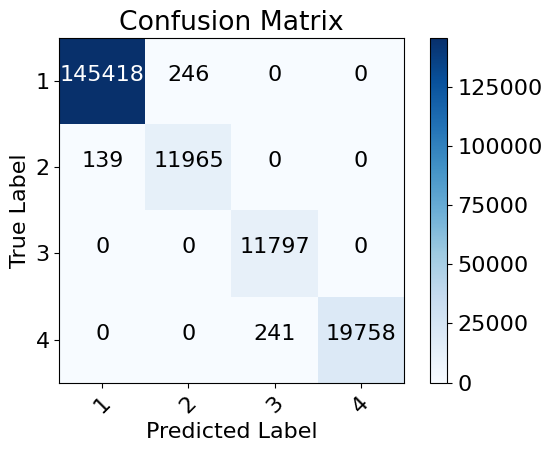

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Get class labels
class_labels = unique_labels(y_test_classes.flatten(), y_pred_classes.flatten())

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix[1:,1:], classes=class_labels[1:], title='Confusion Matrix')
plt.show()

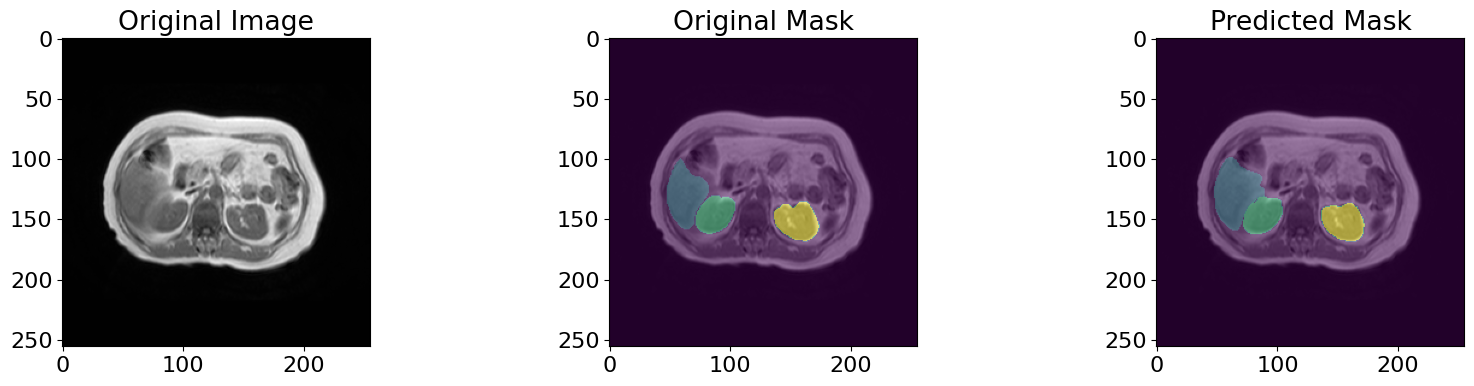

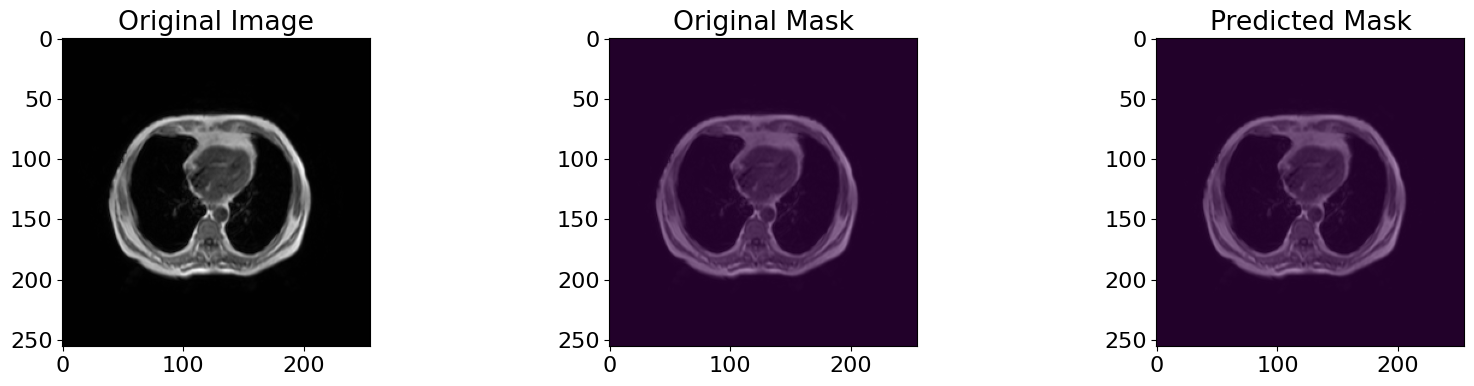

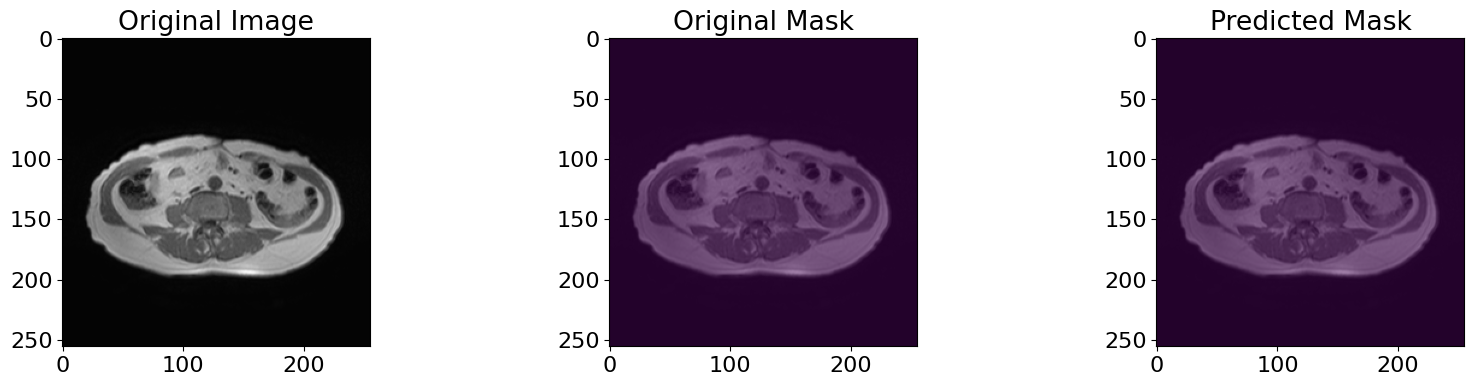

In [ ]:
# Define a function to plot triptychs for model predictions
def plot_triptychs(data, labels, index=None):
    # If index is not specified, randomly select one
    if index is None:
        index = np.random.randint(0, len(data))

    # Generate predictions for the selected index
    pred = custom_model.predict(np.expand_dims(data[index], axis=0), verbose=0)
    pred = np.array(tf.math.argmax(pred, axis=-1))
    pred = np.reshape(pred, (256, 256, 1))

    # Plot the original image, original mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))
    axes[0].set_title("Original Image")
    axes[0].imshow(data[index], cmap='gray')
    axes[1].set_title("Original Mask")
    axes[1].imshow(data[index], cmap='gray')
    #colored_image = display_color_mapped_image_continuous(labels[index])
    axes[1].imshow(np.squeeze(labels[index]),alpha=0.5)
    axes[2].set_title("Predicted Mask")
    axes[2].imshow(data[index], cmap='gray')
    #colored_image = display_color_mapped_image_continuous(pred)
    axes[2].imshow(np.squeeze(pred), alpha=0.5)
    plt.show()

# Plot triptychs for three random samples from the test set
plot_triptychs(X_test, y_test)
plot_triptychs(X_test, y_test)
plot_triptychs(X_test, y_test)